In [1]:
import stageemi
import stageemi.dev.distance_wwmf as distance_wwmf
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os 
import numpy as np
import pandas as pd
from datetime import datetime
import glob 
import time

In [3]:
path="../../WWMF/"
time_str='202001260000'
fname=sorted(glob.glob(path+"*"+'20200126000000'+"*"))[0]

## On ouvre les fichiers 

In [5]:
zone_dpt="41"
fname_mask='../../GeoData/zones_sympo_multiples/'+zone_dpt+'_mask_zones_sympos.nc'
da_mask=xr.open_dataarray(fname_mask,chunks={"id":1})

da_mask['latitude']=da_mask['latitude'].round(5)
da_mask['latitude']=da_mask['latitude'].round(5)

In [6]:
da_mask

<xarray.DataArray 'mask' (id: 31, latitude: 96, longitude: 169)>
dask.array<open_dataset-227f3d2d6e526f733680c80144332fbbmask, shape=(31, 96, 169), dtype=float32, chunksize=(1, 96, 169), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGround  int64 ...
    time               datetime64[ns] ...
    valid_time         datetime64[ns] ...
    step               timedelta64[ns] ...
  * latitude           (latitude) float64 47.2 47.21 47.22 ... 48.13 48.14 48.15
  * longitude          (longitude) float64 0.57 0.58 0.59 0.6 ... 2.23 2.24 2.25
  * id                 (id) object 'departement' ... '4102+4103+4104+4105+4106'

In [4]:
#add as attribute the size of the zone (in number of pixels)
zone_size_l=[len(np.where(da_mask.isel(id=i)==1)[0]) for i in np.arange(0,31)]
da_mask.attrs["zone size"]=zone_size_l
#da_mask

In [5]:
ds=xr.open_dataset(fname,chunks={"step":1})
ds['latitude']=ds['latitude'].round(5)
ds['longitude']=ds['longitude'].round(5)

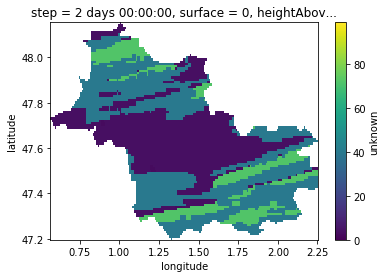

In [9]:
ds_masked=(ds*da_mask.sel(id="departement").drop("id"))
ds_masked.isel(step=47).unknown.plot.imshow(vmin=0,vmax=99)

## Round 1

In [8]:
ds_distance = distance_wwmf.get_pixel_distance_dept(ds_masked,"compas") # 4D (step:48, latitude, longitude, wwmf_2)
#ds_distance

In [9]:
ds_distance_chunk = ds_distance.chunk({"step":1}) # 4D (step:48, latitude, longitude, wwmf_2)
#ds_distance_chunk

In [10]:
distance_by_step_id = (ds_distance_chunk * da_mask).sum(['latitude',"longitude"]).compute() # 3D (step:48, wwmf_2, id)
#distance_by_step_id

/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/dask/array/core.py:3901: PerformanceWarning: Increasing number of chunks by factor of 31
  result = blockwise(


## On affiche la distance minimale pour chacune des timestep/region

In [11]:
dist_by_step_id_min=distance_by_step_id.min("wwmf_2") # 2D (step, id)
ind_dpt=np.where(~dist_by_step_id_min.any(axis=1))[0] # find steps where it is the same weather over the entire dpt
dist_by_step_id_min
#a=dist_by_step_id_min.isel(step=42).plot.line('-^',x='id',figsize=(20,15)) #np.arange(0,48) (display the distance matrix)

<xarray.DataArray (step: 48, id: 31)>
array([[ 2510.,   600.,    60., ...,  2376.,  2473.,  1911.],
       [ 2129.,   112.,    60., ...,  1961.,  2093.,  2018.],
       [ 4642.,  1454.,   472., ...,  4480.,  4618.,  3208.],
       ...,
       [ 9489.,  1964.,   730., ...,  8925.,  8699.,  7428.],
       [11590.,  2304.,  1296., ..., 10708., 11404.,  8976.],
       [10647.,  1302.,   756., ..., 10030.,  9855.,  9355.]])
Coordinates:
  * step               (step) timedelta64[ns] 01:00:00 ... 2 days 00:00:00
    surface            int64 0
    heightAboveGround  int64 2
    time               datetime64[ns] 2019-10-01
    valid_time         datetime64[ns] 2019-10-01T12:00:00
  * id                 (id) object 'departement' ... '4102+4103+4104+4105+4106'

## On affiche le temps sensible correspondant 

In [12]:
distance_by_step_id.wwmf_2[distance_by_step_id.argmin("wwmf_2")] # 2D (step, id)

<xarray.DataArray 'wwmf_2' (step: 48, id: 31)>
array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [6, 8, 6, ..., 6, 6, 6],
       [6, 3, 6, ..., 6, 6, 6],
       [6, 6, 3, ..., 6, 6, 3]])
Coordinates:
    surface            int64 0
    heightAboveGround  int64 2
    wwmf_2             (step, id) int64 4 4 4 4 4 4 4 4 4 ... 6 3 3 6 6 6 6 6 3
    time               datetime64[ns] 2019-10-01
    valid_time         datetime64[ns] 2019-10-01T12:00:00
  * step               (step) timedelta64[ns] 01:00:00 ... 2 days 00:00:00
  * id                 (id) object 'departement' ... '4102+4103+4104+4105+4106'

## On affiche la zone qui minimise la distance pour chaque timestep

In [13]:
df=pd.DataFrame(data=(np.arange(0,48),dist_by_step_id_min.id[dist_by_step_id_min.argmin(("id"))].values))
#np.transpose(df)

## On répète pour les complémentaires des masks

In [14]:
#da_mask.isel(id=30).plot.imshow()
#da_mask.isel(id=30).id
#da_mask_comp.isel(id=30).plot.imshow()
#da_mask_comp.isel(id=30).id

In [14]:
da_mask_comp=-1*(da_mask.isel(id=slice(0,32))-da_mask.isel(id=0))
#da_mask_comp.isel(id=0).plot.imshow()

In [15]:
#add as attribute the size of the zone (in number of pixels)
zone_comp_size_l=[len(np.where(da_mask_comp.isel(id=i)==1)[0]) for i in np.arange(0,31)]
da_mask_comp.attrs["zone size"]=zone_comp_size_l
#da_mask_comp

In [16]:
distance_comp_by_step_id = (ds_distance_chunk * da_mask_comp).sum(['latitude',"longitude"]).compute()
#distance_comp_by_step_id

/Users/gablellouch/anaconda3/envs/preproc/lib/python3.8/site-packages/dask/array/core.py:3901: PerformanceWarning: Increasing number of chunks by factor of 31
  result = blockwise(


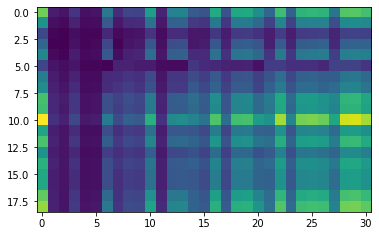

In [17]:
plt.imshow(distance_by_step_id.isel(step=10).values)

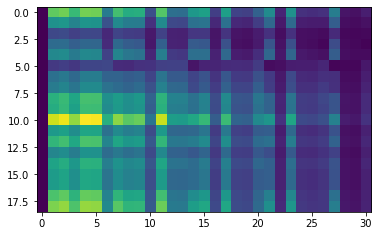

In [18]:
plt.imshow(distance_comp_by_step_id.isel(step=10).values)

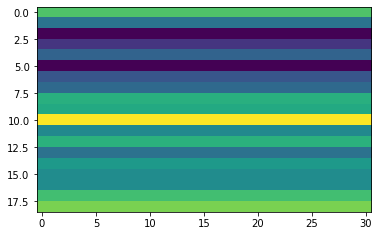

In [19]:
#C'est tout à fait normal d'avoir les memes valeurs pour toutes les zones lorsqu'on somme les 2 matrices
plt.imshow((distance_by_step_id.isel(step=10)+distance_comp_by_step_id.isel(step=10)).values)

In [20]:
#Ce qui nous intéresse c'est de savoir quelle zone permet une somme des distances minimale en prenant le minimum des distances sur toutes les wwmf_2 avec le minimum sur toutes les wwmf_2 de sa zone complémentaire
dist_comp_by_step_id_min=distance_comp_by_step_id.min("wwmf_2") # 2D (step, id)
dist_comp_by_step_id_min[:,1:]

<xarray.DataArray (step: 48, id: 30)>
array([[ 1910.,  2450.,  2125., ...,   134.,    37.,   599.],
       [ 2017.,  2069.,  1780., ...,   168.,    36.,   111.],
       [ 3188.,  4170.,  3792., ...,   162.,    24.,  1434.],
       ...,
       [ 7384.,  8759.,  7933., ...,   564.,   790.,  1853.],
       [ 8912., 10294.,  8992., ...,   246.,   186.,  2194.],
       [ 9299.,  9801.,  8269., ...,   617.,   138.,  1280.]])
Coordinates:
  * step               (step) timedelta64[ns] 01:00:00 ... 2 days 00:00:00
    surface            int64 0
    heightAboveGround  int64 2
    time               datetime64[ns] 2019-10-01
    valid_time         datetime64[ns] 2019-10-01T12:00:00
  * id                 (id) object '4101' '4102' ... '4102+4103+4104+4105+4106'

In [21]:
df_comp=pd.DataFrame(data=(np.arange(0,48),dist_comp_by_step_id_min.id[dist_comp_by_step_id_min.argmin(("id"))].values))
#np.transpose(df_comp)

## On trouve la zone et son complémentaire qui minimizent la somme des distances

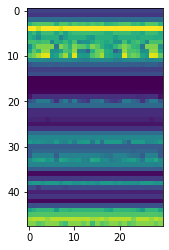

In [22]:
dist_sum_by_step_id_min=dist_by_step_id_min[:,1:]+dist_comp_by_step_id_min[:,1:] #on enlève le cas trivial du la zone "département"
plt.imshow(dist_sum_by_step_id_min)

In [23]:
df_sum=pd.DataFrame(data=(np.arange(0,48),dist_sum_by_step_id_min.id[dist_sum_by_step_id_min.argmin(("id"))].values))
if len(ind_dpt)>0:
    df_sum.iloc[1][ind_dpt]="departement"
np.transpose(df_sum)

,0,1
0,0,4101
1,1,4101
2,2,4101+4102+4103+4104+4105
3,3,4103+4104+4105+4106
4,4,4103
5,5,4103
6,6,4102+4103
7,7,4106
8,8,4103+4104+4105+4106
9,9,4104+4105+4106


In [24]:
# on remonte au temps sensible pour la winning zone
# d'abord les indices de la winning zone au sens du minimum de la somme des distances
ind_winning_zone=dist_sum_by_step_id_min.argmin(("id")).values+1 # +1 parce que la matrice dist_sum_by_step_id_min a la premiere colonne (departement) en moins
ind_winning_zone

# on remonte au temps sensible pour la winning zone
tps_sensible_winning_zone=distance_by_step_id.wwmf_2[distance_by_step_id.argmin("wwmf_2").values[np.arange(0,ds_masked.dims['step']),ind_winning_zone]]

# puis au temps sensible pour la zone complementaire de la winning zone
tps_sensible_winning_zone_comp=distance_comp_by_step_id.wwmf_2[distance_comp_by_step_id.argmin("wwmf_2").values[np.arange(0,ds_masked.dims['step']),ind_winning_zone]]

In [25]:
tps_sensible_winning_zone

<xarray.DataArray 'wwmf_2' (wwmf_2: 48)>
array([ 4,  4,  4,  4, 12,  6,  6,  3,  6,  6,  6,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  6,  6,  6,  6,  8,  6,  6,  6,  6,  3,  3,  6,  6,  6,  6,  6,
        6,  6,  8,  8,  6,  6,  6, 12,  6,  6,  6,  3])
Coordinates:
    surface            int64 0
    heightAboveGround  int64 2
  * wwmf_2             (wwmf_2) int64 4 4 4 4 12 6 6 3 6 ... 8 6 6 6 12 6 6 6 3
    time               datetime64[ns] 2019-10-01
    valid_time         datetime64[ns] 2019-10-01T12:00:00

In [26]:
tps_sensible_winning_zone_comp

<xarray.DataArray 'wwmf_2' (wwmf_2: 48)>
array([ 4,  4,  3,  3,  3,  3,  3,  6,  4,  4,  4,  4,  4,  3,  3,  3,  3,  3,
        3,  6,  3,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  3,  3,  3, 12,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  3,  8,  3,  6])
Coordinates:
    surface            int64 0
    heightAboveGround  int64 2
  * wwmf_2             (wwmf_2) int64 4 4 3 3 3 3 3 6 4 4 ... 6 6 6 6 6 3 8 3 6
    time               datetime64[ns] 2019-10-01
    valid_time         datetime64[ns] 2019-10-01T12:00:00

## On itère une seconde fois pour rediviser les zones qui présentent une densité de distance (distance moyenne par pixel) supérieure à la densité de distance médiane sur le département et l'ensemble des échéances.

## Calcul de la densité de distance médiane sur le département et l'ensemble des échéances

## Zones

In [27]:
dist_min_by_step=dist_by_step_id_min[:,dist_by_step_id_min.argmin(("id"))]
dist_min_by_step.values

array([ 59.,  57.,  43.,  75., 698., 169., 127., 344.,   0., 116., 276.,
        28.,  90.,  46.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,  90.,   0.,   0., 106.,   0.,   0.,   0.,
         0., 120.,   0.,   0.,   0., 340.,   0.,   0.,   0.,   0.,   0.,
       576., 644., 284., 202.])

In [29]:
zone_with_dist_min_by_step=dist_by_step_id_min.argmin(("id"))
zone_with_dist_min_by_step.values

array([4, 4, 4, 4, 5, 1, 5, 2, 5, 5, 2, 1, 5, 1, 1, 1, 0, 0, 2, 3, 1, 2,
       2, 3, 2, 3, 2, 5, 1, 5, 4, 4, 4, 1, 3, 4, 3, 4, 4, 1, 1, 4, 6, 4,
       5, 5, 4, 4])

## Complementary zones

In [30]:
dist_comp_by_step_id_min_dropcol1=dist_comp_by_step_id_min[:,1:]
dist_comp_by_step_id_min_dropcol1.values[0,:]

array([1910., 2450., 2125., 2451., 2376., 1214., 1851., 2065., 2075.,
        830., 2317., 1169., 1080., 1466., 2015.,  770., 1941.,  793.,
        696., 1035., 1416.,  171., 1881.,  733.,  636.,  659., 1282.,
        134.,   37.,  599.])

In [31]:
dist_comp_min_by_step=dist_comp_by_step_id_min_dropcol1[:,dist_comp_by_step_id_min_dropcol1.argmin(("id"))]
dist_comp_min_by_step.values

array([ 37.,  36.,  24.,  54., 600., 132., 107., 472.,   0.,  86., 626.,
        11.,  66.,  46.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,  44.,   0.,  76.,   0.,   0.,  98.,   0.,   0.,   0.,
         0., 308.,   0.,   0.,   0., 316.,   0.,   0.,   0.,   0.,   0.,
       488., 564., 186., 138.])

In [32]:
zone_comp_with_dist_min_by_step=dist_comp_by_step_id_min_dropcol1.argmin(("id"))+1 # +1 is to compensate for the first column (complementary of the departement that we dropped)
zone_comp_with_dist_min_by_step.values

array([29, 29, 29, 29, 28, 30, 28, 28, 28, 28, 30, 30, 28, 30, 30,  6,  1,
        1,  1,  7, 27, 29, 22, 29, 29, 27, 28, 28, 30, 28, 22, 29, 22, 28,
       30, 22,  7, 22, 29, 30, 25, 27, 27, 29, 28, 28, 29, 29])

## Zones and complementary zones together

In [33]:
dist_min_sum_by_step=dist_sum_by_step_id_min[:,dist_sum_by_step_id_min.argmin(("id"))]
dist_min_sum_by_step.values

array([ 2510.,  2129.,  4546.,  8316., 12049.,  7395.,  5900.,  6171.,
        5092.,  4158.,  7044.,  5575.,  3428.,  2472.,  3147.,    41.,
           0.,     0.,   216.,   626.,  1874.,  4438.,  1712.,  1658.,
        1016.,   734.,  1886.,  4682.,  6010.,  4244.,  3724.,  3583.,
        3762.,  5202.,  5714.,  3716.,   400.,  2188.,  6354.,  2230.,
        1252.,  1996.,   340.,  3070.,  7088.,  9281., 10534.,  8943.])

In [34]:
zone_sum_with_dist_min_by_step=dist_sum_by_step_id_min.argmin(("id"))+1 # +1 is to compensate for the first column (complementary of the departement that we dropped)
zone_sum_with_dist_min_by_step.values

array([ 1,  1, 27, 26,  3,  3,  8,  6, 26, 20, 20, 13, 30,  1,  1,  1,  1,
        1,  1, 30,  7,  1,  1,  1,  5,  1,  1,  1,  1, 23, 30,  1,  1,  7,
       29,  1,  1,  1, 16,  3,  1,  1,  1,  2, 26, 30, 24, 15])

## Density for all zones and their complementary zones

In [35]:
# find distance values for zones that when combined with their complementary zone gave the min distance
dist_min_by_step_fordensity=dist_by_step_id_min[:,zone_sum_with_dist_min_by_step]
dist_min_by_step_fordensity.values

array([6.000e+02, 1.120e+02, 2.912e+03, 4.141e+03, 3.795e+03, 3.224e+03,
       2.132e+03, 2.477e+03, 4.382e+03, 7.680e+02, 3.072e+03, 4.586e+03,
       3.201e+03, 4.600e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       2.160e+02, 1.600e+02, 8.000e+00, 5.060e+02, 5.120e+02, 7.800e+02,
       4.360e+02, 2.080e+02, 2.780e+02, 2.340e+02, 0.000e+00, 2.086e+03,
       1.958e+03, 1.084e+03, 2.200e+02, 4.840e+02, 4.898e+03, 5.200e+02,
       2.860e+02, 9.540e+02, 4.608e+03, 1.276e+03, 0.000e+00, 1.420e+02,
       4.400e+01, 1.452e+03, 5.572e+03, 7.428e+03, 8.094e+03, 2.322e+03])

In [36]:
# find distance values for the complementary zones in question
dist_comp_min_by_step_fordensity=dist_comp_by_step_id_min[:,zone_sum_with_dist_min_by_step]
dist_comp_min_by_step_fordensity.values

array([1910., 2017., 1634., 4175., 8254., 4171., 3768., 3694.,  710.,
       3390., 3972.,  989.,  227., 2426., 3147.,   41.,    0.,    0.,
          0.,  466., 1866., 3932., 1200.,  878.,  580.,  526., 1608.,
       4448., 6010., 2158., 1766., 2499., 3542., 4718.,  816., 3196.,
        114., 1234., 1746.,  954., 1252., 1854.,  296., 1618., 1516.,
       1853., 2440., 6621.])

In [37]:
# check that when we sum them up we retrieve the values we found earlier in "Zones and complementary zones together"
dist_min_by_step_fordensity.values+dist_comp_min_by_step_fordensity.values

array([ 2510.,  2129.,  4546.,  8316., 12049.,  7395.,  5900.,  6171.,
        5092.,  4158.,  7044.,  5575.,  3428.,  2472.,  3147.,    41.,
           0.,     0.,   216.,   626.,  1874.,  4438.,  1712.,  1658.,
        1016.,   734.,  1886.,  4682.,  6010.,  4244.,  3724.,  3583.,
        3762.,  5202.,  5714.,  3716.,   400.,  2188.,  6354.,  2230.,
        1252.,  1996.,   340.,  3070.,  7088.,  9281., 10534.,  8943.])

In [38]:
zone_size_distmin=[zone_size_l[zone_sum_with_dist_min_by_step.values[i]] for i in np.arange(0,48)]

In [39]:
# compute the median density of the zones with min "sum of distances"
density_dist_min_by_step=dist_min_by_step_fordensity.values/zone_size_distmin
density_dist_min_by_step_median=np.median(density_dist_min_by_step)
density_dist_min_by_step_median

0.4854186265286924

In [40]:
zone_comp_size_distmin=[zone_comp_size_l[zone_sum_with_dist_min_by_step.values[i]] for i in np.arange(0,48)]

In [41]:
# compute the median density of the complementary zones
density_dist_comp_min_by_step=dist_comp_min_by_step_fordensity.values/zone_comp_size_distmin
density_dist_comp_min_by_step_median=np.median(density_dist_comp_min_by_step)
density_dist_comp_min_by_step_median

0.43538449575526933

## Recherche des échéances qui présentent des zones répondant à cette condition et qui sont composées de plusieurs zones sympo

## Zones

In [42]:
# find the echeance steps with heterogeneous winning zones (in terms of the criterion of homogeneity: the sum of the distances is minimum)
step_zones_hetero=np.where(density_dist_min_by_step>density_dist_min_by_step_median)[0]
step_zones_hetero

array([ 0,  2,  3,  4,  5,  6,  7,  8, 10, 11, 23, 24, 29, 31, 34, 35, 37,
       38, 39, 43, 44, 45, 46, 47])

In [43]:
# find the zones with multiple zones sympo in it 
id_zones_multiple=np.where(['+' in val for val in da_mask.id.values.tolist()])[0]
#id_zones_multiple

In [44]:
# remember the winning zones per echeance
zone_sum_with_dist_min_by_step.values

array([ 1,  1, 27, 26,  3,  3,  8,  6, 26, 20, 20, 13, 30,  1,  1,  1,  1,
        1,  1, 30,  7,  1,  1,  1,  5,  1,  1,  1,  1, 23, 30,  1,  1,  7,
       29,  1,  1,  1, 16,  3,  1,  1,  1,  2, 26, 30, 24, 15])

In [45]:
# remember the winning zones per echeance that are heterogenous 
zone_sum_with_dist_min_by_step.values[step_zones_hetero]

array([ 1, 27, 26,  3,  3,  8,  6, 26, 20, 13,  1,  5, 23,  1, 29,  1,  1,
       16,  3,  2, 26, 30, 24, 15])

In [46]:
# mark those echeances that have both heterogeneous winning zones and are composed of multiple zone sympo
step_zones_hetero_and_multiple=step_zones_hetero[np.where([zone_sum_with_dist_min_by_step.values[step_zones_hetero][i] in id_zones_multiple for i in np.arange(0,len(step_zones_hetero))])[0]]
step_zones_hetero_and_multiple

array([ 2,  3,  6,  8, 10, 11, 29, 34, 38, 44, 45, 46, 47])

In [47]:
# and the zones are the following:
zones=[da_mask.id.values.tolist()[zone_sum_with_dist_min_by_step.values[i]] for i in step_zones_hetero_and_multiple]
zones

['4101+4102+4103+4104+4105',
 '4103+4104+4105+4106',
 '4102+4103',
 '4103+4104+4105+4106',
 '4104+4105+4106',
 '4105+4106',
 '4102+4103+4104+4105',
 '4101+4102+4103+4105+4106',
 '4102+4103+4106',
 '4103+4104+4105+4106',
 '4102+4103+4104+4105+4106',
 '4102+4103+4104+4106',
 '4102+4103+4104']

## Complementary zones

In [48]:
# for the echeance steps with heterogeneous complementary winning zones
step_zones_comp_hetero=np.where(density_dist_comp_min_by_step>density_dist_comp_min_by_step_median)[0]
step_zones_comp_hetero

array([ 2,  3,  4,  5,  6,  7,  9, 10, 14, 19, 21, 27, 28, 29, 30, 32, 33,
       34, 35, 38, 44, 45, 46, 47])

In [49]:
# nb of zones sympo in the department (to know the indices of the complementary zones with multiple zones sympo)
zs_N=len([zs for zs in da_mask.id.values.tolist() if "+" not in zs])-1 # -1 to remove the departement from the counting

In [50]:
# find the complementary zones with multiple zones sympo in it 
id_zones_comp_multiple=np.where([val.count('+')<(zs_N-2) for val in da_mask.id.values.tolist()])[0][1:] # we ignore the department since the complementary zone is the empty space
id_zones_comp_multiple

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

In [51]:
# remember the winning zones per echeance
zone_sum_with_dist_min_by_step.values

array([ 1,  1, 27, 26,  3,  3,  8,  6, 26, 20, 20, 13, 30,  1,  1,  1,  1,
        1,  1, 30,  7,  1,  1,  1,  5,  1,  1,  1,  1, 23, 30,  1,  1,  7,
       29,  1,  1,  1, 16,  3,  1,  1,  1,  2, 26, 30, 24, 15])

In [52]:
# remember the winning zones per echeance that are heterogenous 
zone_sum_with_dist_min_by_step.values[step_zones_comp_hetero]

array([27, 26,  3,  3,  8,  6, 20, 20,  1, 30,  1,  1,  1, 23, 30,  1,  7,
       29,  1, 16, 26, 30, 24, 15])

In [53]:
# mark those echeances that have both heterogeneous winning complementary zones and are composed of multiple zone sympo
step_zones_comp_hetero_and_multiple=step_zones_comp_hetero[np.where([zone_sum_with_dist_min_by_step.values[step_zones_comp_hetero][i] in id_zones_comp_multiple for i in np.arange(0,len(step_zones_hetero))])[0]]
step_zones_comp_hetero_and_multiple

array([ 3,  4,  5,  6,  7,  9, 10, 14, 21, 27, 28, 29, 32, 33, 35, 38, 44,
       46, 47])

In [54]:
# and the complementary zones are the following (in fact they are the complementary of these zones):
zones_comp=[da_mask.id.values.tolist()[zone_sum_with_dist_min_by_step.values[i]] for i in step_zones_comp_hetero_and_multiple]
zones_comp

['4103+4104+4105+4106',
 '4103',
 '4103',
 '4102+4103',
 '4106',
 '4104+4105+4106',
 '4104+4105+4106',
 '4101',
 '4101',
 '4101',
 '4101',
 '4102+4103+4104+4105',
 '4101',
 '4101+4102',
 '4101',
 '4102+4103+4106',
 '4103+4104+4105+4106',
 '4102+4103+4104+4106',
 '4102+4103+4104']

## We generate the dataarray of masks of the winning heterogeneous zones + complementary zones with multiple zone sympo. Zones that did not pass the criteria are fully masked.


## Recall the zones and complementary zones

In [55]:
# adding the zone and its complementary we get the department size
np.asarray(da_mask.attrs["zone size"])+np.asarray(da_mask_comp.attrs["zone size"])

array([7901, 7901, 7901, 7901, 7901, 7901, 7901, 7901, 7901, 7901, 7901,
       7901, 7901, 7901, 7901, 7901, 7901, 7901, 7901, 7901, 7901, 7901,
       7901, 7901, 7901, 7901, 7901, 7901, 7901, 7901, 7901])

## Zones

In [56]:
# create the dataarray where masks corresponding to zones that shall be redivided (zones) are applied on the appropriate echeance step (step_zones_hetero_and_multiple)
tmp_masks=np.full([ds_masked.dims['step'], ds_masked.dims['latitude'], ds_masked.dims['longitude']], np.nan)

In [57]:
for i in np.arange(0,ds.dims['step']):  
    if i in step_zones_hetero_and_multiple: 
        ind_tmp=zone_sum_with_dist_min_by_step.values[i]
        mask_tmp=da_mask.isel(id=ind_tmp)
        mask_tmp=mask_tmp.where(mask_tmp!=0,np.nan)        
        tmp_masks[i,:,:]=(ds.isel(step=i).unknown*mask_tmp).values 

In [58]:
np.shape(tmp_masks)

(48, 96, 169)

In [59]:
# build the new ds
ds_masked_zones_hetero=xr.Dataset(coords={'step':ds_masked['step'],'latitude':ds_masked['latitude'],'longitude':ds_masked['longitude']})
ds_masked_zones_hetero["unknown"]=(tuple(['step','latitude','longitude']),tmp_masks)
ds_masked_zones_hetero

<xarray.Dataset>
Dimensions:            (latitude: 96, longitude: 169, step: 48)
Coordinates:
    surface            int64 0
    heightAboveGround  int64 2
  * step               (step) timedelta64[ns] 01:00:00 ... 2 days 00:00:00
  * latitude           (latitude) float64 48.15 48.14 48.13 ... 47.22 47.21 47.2
  * longitude          (longitude) float64 0.57 0.58 0.59 0.6 ... 2.23 2.24 2.25
Data variables:
    unknown            (step, latitude, longitude) float64 nan nan ... nan nan

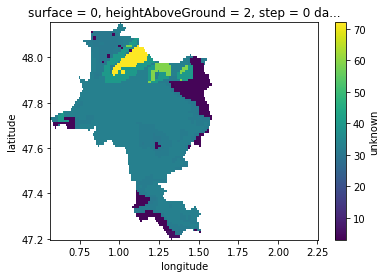

In [60]:
ds_masked_zones_hetero.isel(step=2).unknown.plot.imshow();

## Complementary zones

In [61]:
# create the dataarray where masks corresponding to complementary zones that shall be redivided (zones_comp) are applied on the appropriate echeance step (step_zones_comp_hetero_and_multiple)
tmp_masks_comp=np.full([ds_masked.dims['step'], ds_masked.dims['latitude'], ds_masked.dims['longitude']], np.nan)

In [62]:
for i in np.arange(0,ds.dims['step']):  
    if i in step_zones_comp_hetero_and_multiple: 
        ind_comp_tmp=zone_sum_with_dist_min_by_step.values[i]
        
        mask_comp_tmp=da_mask_comp.isel(id=ind_comp_tmp)
        mask_comp_tmp=mask_comp_tmp.where(mask_comp_tmp!=0,np.nan) 
        
        tmp_masks_comp[i,:,:]=(ds.isel(step=i).unknown*mask_comp_tmp).values 

In [63]:
# include 
ds_masked_zones_comp_hetero=xr.Dataset(coords={'step':ds_masked['step'],'latitude':ds_masked['latitude'],'longitude':ds_masked['longitude']})
ds_masked_zones_comp_hetero["unknown"]=(tuple(['step','latitude','longitude']),tmp_masks_comp)
ds_masked_zones_comp_hetero

<xarray.Dataset>
Dimensions:            (latitude: 96, longitude: 169, step: 48)
Coordinates:
    surface            int64 0
    heightAboveGround  int64 2
  * step               (step) timedelta64[ns] 01:00:00 ... 2 days 00:00:00
  * latitude           (latitude) float64 48.15 48.14 48.13 ... 47.22 47.21 47.2
  * longitude          (longitude) float64 0.57 0.58 0.59 0.6 ... 2.23 2.24 2.25
Data variables:
    unknown            (step, latitude, longitude) float64 nan nan ... nan nan

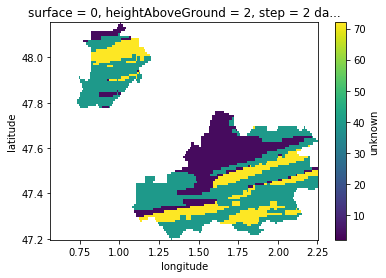

In [413]:
ds_masked_zones_comp_hetero.isel(step=47).unknown.plot.imshow();

## Round 2: apply the distance calculation on these two new datasets composed of the heterogeneous winning zones and complementary zones

## A. Winning zones

## 1. Zones for the winning zones

In [64]:
ds_distance_round2zones = distance_wwmf.get_pixel_distance_dept(ds_masked_zones_hetero,"compas") # 4D (step:48, latitude, longitude, wwmf_2)

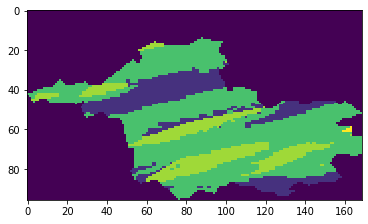

In [65]:
plt.imshow(ds_distance_round2zones.isel(step=45).isel(wwmf_2=4))

In [67]:
ds_distance_round2zones_chunk = ds_distance_round2zones.chunk({"step":1}) # 4D (step:48, latitude, longitude, wwmf_2)
#ds_distance_round2zones_chunk

In [68]:
# rappel des echeances concernees
step_zones_hetero_and_multiple

array([ 2,  3,  6,  8, 10, 11, 29, 34, 38, 44, 45, 46, 47])

In [73]:
distance_round2zones_by_step_id = (ds_distance_round2zones_chunk * da_mask_round2).sum(['latitude',"longitude"]).compute() # 3D (step:48, wwmf_2, id)
#distance_round2zones_by_step_id = (ds_distance_round2zones_chunk * da_mask).sum(['latitude',"longitude"]).compute() # 3D (step:48, wwmf_2, id)
#distance_round2zones_by_step_id

## Testing the new DEBUG idea (to solve the problem that comes later) modify the mask, value 0 -> nan

In [70]:
tmp_mask_round2=np.full([da_mask.shape[0], da_mask.shape[1], da_mask.shape[2]], np.nan)

In [71]:
# initialization
da_mask_round2=da_mask

for i in np.arange(0,da_mask.shape[0]):   
    mask_tmp_round2=da_mask.isel(id=i)
    mask_tmp_round2=mask_tmp_round2.where(mask_tmp_round2!=0,np.nan)  
    tmp_mask_round2[i,:,:]=mask_tmp_round2

In [72]:
da_mask_round2=xr.DataArray(data=tmp_mask_round2,coords={'id':da_mask.id.values,'latitude':da_mask.latitude.values,'longitude':da_mask.longitude.values},dims={'id':da_mask.shape[0],'latitude':da_mask.shape[1],'longitude':da_mask.shape[2]})
#da_mask_round2

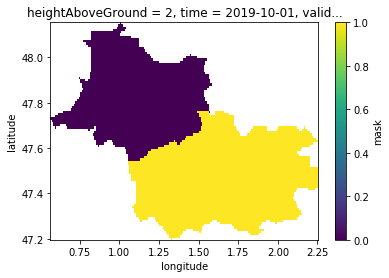

In [74]:
da_mask.isel(id=20).plot.imshow()

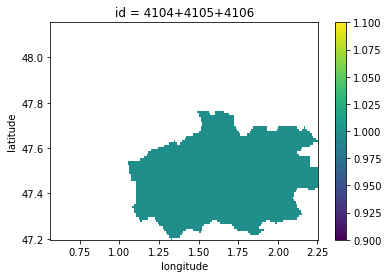

In [75]:
da_mask_round2.isel(id=20).plot.imshow()

In [74]:
tmp_mask_comp_round2=np.full([da_mask.shape[0], da_mask.shape[1], da_mask.shape[2]], np.nan)

In [75]:
# initialization
da_mask_comp_round2=da_mask_comp

for i in np.arange(0,da_mask.shape[0]):   
    mask_comp_tmp_round2=da_mask_comp.isel(id=i)
    mask_comp_tmp_round2=mask_comp_tmp_round2.where(mask_comp_tmp_round2!=0,np.nan)  
    tmp_mask_comp_round2[i,:,:]=mask_comp_tmp_round2

In [76]:
da_mask_comp_round2=xr.DataArray(data=tmp_mask_comp_round2,coords={'id':da_mask.id.values,'latitude':da_mask.latitude.values,'longitude':da_mask.longitude.values},dims={'id':da_mask.shape[0],'latitude':da_mask.shape[1],'longitude':da_mask.shape[2]})
da_mask_comp_round2

<xarray.DataArray (id: 31, latitude: 96, longitude: 169)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * id         (id) object 'departement' '4101' ... '4102+4103+4104+4105+4106'
  * latitude   (latitude) float64 47.2 47.21 47.22 47.23 ... 48.13 48.14 48.15
  * longitude  (longitude) float64 0.57 0.58 0.59 0.6 ... 2.22 2.23 2.24 2.25

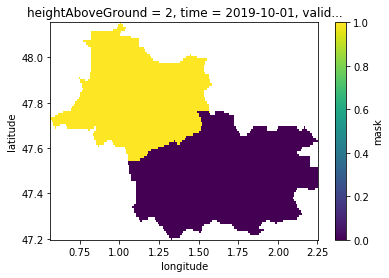

In [79]:
da_mask_comp.isel(id=20).plot.imshow()

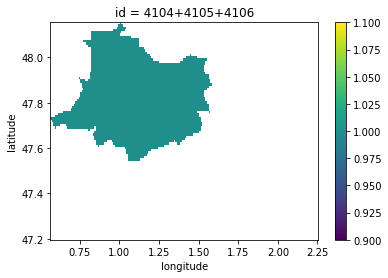

In [80]:
da_mask_comp_round2.isel(id=20).plot.imshow()

## End of the new DEBUG idea

In [77]:
#list of the zones hetero and multiple (rappel de plus haut)
zoneswinning=dist_sum_by_step_id_min.id[dist_sum_by_step_id_min.argmin(("id"))].values
zoneswinning

array(['4101', '4101', '4101+4102+4103+4104+4105', '4103+4104+4105+4106',
       '4103', '4103', '4102+4103', '4106', '4103+4104+4105+4106',
       '4104+4105+4106', '4104+4105+4106', '4105+4106',
       '4102+4103+4104+4105+4106', '4101', '4101', '4101', '4101', '4101',
       '4101', '4102+4103+4104+4105+4106', '4101+4102', '4101', '4101',
       '4101', '4105', '4101', '4101', '4101', '4101',
       '4102+4103+4104+4105', '4102+4103+4104+4105+4106', '4101', '4101',
       '4101+4102', '4101+4102+4103+4105+4106', '4101', '4101', '4101',
       '4102+4103+4106', '4103', '4101', '4101', '4101', '4102',
       '4103+4104+4105+4106', '4102+4103+4104+4105+4106',
       '4102+4103+4104+4106', '4102+4103+4104'], dtype=object)

In [78]:
# find the id of the subset of zones included in the winning zone for each echeance step when round 2 is applicable
id_zone_included=[np.nan]*ds_masked.dims['step']

for i in step_zones_hetero_and_multiple:
    id_zone_included[i]=np.where([set(val.split("+")).issubset(zoneswinning[i].split("+")) for val in da_mask.id.values.tolist()])[0]

In [79]:
# verify that this works well by comparing one zone and the corresponding subzones
zoneswinning[47]
[da_mask.id.values.tolist()[i] for i in id_zone_included[47]]

['4102', '4103', '4104', '4102+4103', '4103+4104', '4102+4103+4104']

## 2. Complementary zones for the winning zones

In [80]:
distance_round2zones_comp_by_step_id = (ds_distance_round2zones_chunk * da_mask_comp_round2).sum(['latitude',"longitude"]).compute()
#distance_round2zones_comp_by_step_id = (ds_distance_round2zones_chunk * da_mask_comp).sum(['latitude',"longitude"]).compute()
#distance_round2zones_comp_by_step_id

## On trouve la zone et son complémentaire parmi les winning zones qui minimizent la somme des distances 

ATTENTION: JE PENSE QU'ON EST DANS DES CAS OU FINALEMENT LE MEME CODE COMPAS EST RESPONSABLE DU MIN DANS LA ZONE ET SON COMPLEMENTAIRE)

In [81]:
# Cette intuition est bien confirmee en regardant les valeur des codes qui donnent les distances min pour chaque zone
j=6
distance_round2zones_by_step_id.isel(step=j).argmin("wwmf_2")[id_zone_included[j]]

<xarray.DataArray (id: 3)>
array([5, 5, 5])
Coordinates:
    step               timedelta64[ns] 07:00:00
    surface            int64 0
    heightAboveGround  int64 2
  * id                 (id) object '4102' '4103' '4102+4103'

In [82]:
j=6
distance_round2zones_comp_by_step_id.isel(step=j).argmin("wwmf_2")[id_zone_included[j]]

<xarray.DataArray (id: 3)>
array([5, 5, 0])
Coordinates:
    step               timedelta64[ns] 07:00:00
    surface            int64 0
    heightAboveGround  int64 2
  * id                 (id) object '4102' '4103' '4102+4103'

In [85]:
j=6
dist_round2zones_sum_by_step_id_min.isel(step=j)[id_zone_included[j]]

<xarray.DataArray (id: 3)>
array([2132., 2132., 2132.])
Coordinates:
    step               timedelta64[ns] 07:00:00
    surface            int64 0
    heightAboveGround  int64 2
  * id                 (id) object '4102' '4103' '4102+4103'

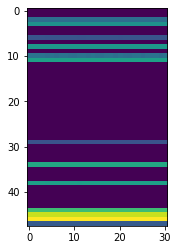

In [86]:
#dist_by_step_id_min=distance_by_step_id.min("wwmf_2")  
distance_round2zones_by_step_id_min=distance_round2zones_by_step_id.min("wwmf_2")

#dist_comp_by_step_id_min=distance_comp_by_step_id.min("wwmf_2") # 2D (step, id)
distance_round2zones_comp_by_step_id_min=distance_round2zones_comp_by_step_id.min("wwmf_2")

#dist_sum_by_step_id_min=dist_by_step_id_min[:,1:]+dist_comp_by_step_id_min[:,1:] #on enlève le cas trivial du la zone "département"
dist_round2zones_sum_by_step_id_min=distance_round2zones_by_step_id_min+distance_round2zones_comp_by_step_id_min

plt.imshow(dist_round2zones_sum_by_step_id_min)

In [87]:
step_zones_hetero_and_multiple

array([ 2,  3,  6,  8, 10, 11, 29, 34, 38, 44, 45, 46, 47])

In [88]:
distance_round2zones_by_step_id_min.isel(step=2)[id_zone_included[2]]

<xarray.DataArray (id: 15)>
array([1454.,  472.,  850.,   43.,  163., 1906., 1280.,  885.,  206.,
       2714., 1315., 1048., 2749., 1478., 2912.])
Coordinates:
    step               timedelta64[ns] 03:00:00
    surface            int64 0
    heightAboveGround  int64 2
  * id                 (id) object '4101' '4102' ... '4101+4102+4103+4104+4105'

In [89]:
distance_round2zones_comp_by_step_id_min.isel(step=2)[id_zone_included[2]]

<xarray.DataArray (id: 15)>
array([1458., 2440., 2062., 2869., 2749., 1006., 1632., 2027., 2706.,
        198., 1597., 1864.,  163., 1434.,    0.])
Coordinates:
    step               timedelta64[ns] 03:00:00
    surface            int64 0
    heightAboveGround  int64 2
  * id                 (id) object '4101' '4102' ... '4101+4102+4103+4104+4105'

In [90]:
# POURQUOI OBTIENT ON LA MEME VALEUR DANS TOUS LES CAS SAUF POUR STEP=10?
i=2
dist_round2zones_sum_by_step_id_min.isel(step=i)[id_zone_included[i]]

<xarray.DataArray (id: 15)>
array([2912., 2912., 2912., 2912., 2912., 2912., 2912., 2912., 2912.,
       2912., 2912., 2912., 2912., 2912., 2912.])
Coordinates:
    step               timedelta64[ns] 03:00:00
    surface            int64 0
    heightAboveGround  int64 2
  * id                 (id) object '4101' '4102' ... '4101+4102+4103+4104+4105'

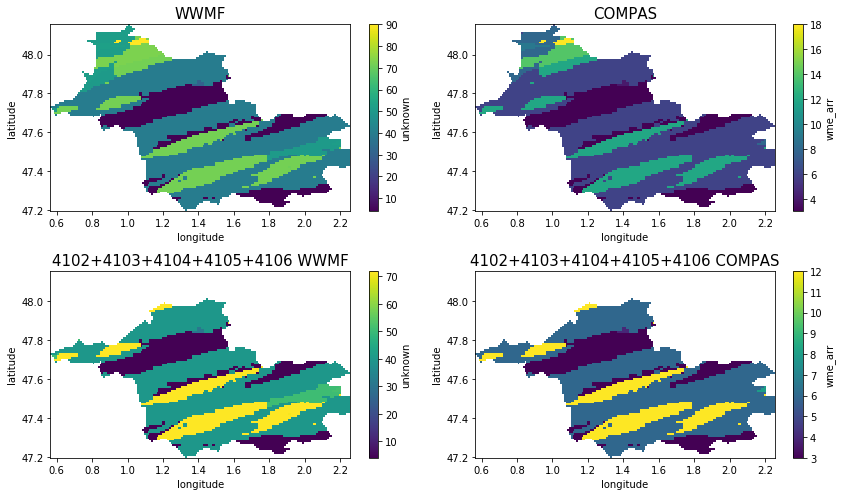

In [91]:
i=45
fig,axes = plt.subplots(nrows=2,ncols = 2,figsize=(12,7))
ax = axes.flat
ds_masked.isel(step=i).unknown.plot.imshow(ax=ax[0]);ax[0].set_title("WWMF",fontsize=15)
ds_masked.isel(step=i).wme_arr.plot.imshow(ax=ax[1]);ax[1].set_title("COMPAS",fontsize=15)
ds_masked_zones_hetero.isel(step=i).unknown.plot.imshow(ax=ax[2]);ax[2].set_title(zoneswinning[i]+" WWMF",fontsize=15)
ds_masked_zones_hetero.isel(step=i).wme_arr.plot.imshow(ax=ax[3]);ax[3].set_title(zoneswinning[i]+" COMPAS",fontsize=15)
plt.tight_layout()

In [93]:
zoneswinning

array(['4101', '4101', '4101+4102+4103+4104+4105', '4103+4104+4105+4106',
       '4103', '4103', '4102+4103', '4106', '4103+4104+4105+4106',
       '4104+4105+4106', '4104+4105+4106', '4105+4106',
       '4102+4103+4104+4105+4106', '4101', '4101', '4101', '4101', '4101',
       '4101', '4102+4103+4104+4105+4106', '4101+4102', '4101', '4101',
       '4101', '4105', '4101', '4101', '4101', '4101',
       '4102+4103+4104+4105', '4102+4103+4104+4105+4106', '4101', '4101',
       '4101+4102', '4101+4102+4103+4105+4106', '4101', '4101', '4101',
       '4102+4103+4106', '4103', '4101', '4101', '4101', '4102',
       '4103+4104+4105+4106', '4102+4103+4104+4105+4106',
       '4102+4103+4104+4106', '4102+4103+4104'], dtype=object)

In [96]:
# initialize
ind_zone_distmin_round2_by_step=np.full([ds_masked_zones_hetero.dims["step"]], np.nan) 
dist_round2_sum_by_step_min=np.full([ds_masked_zones_hetero.dims["step"]], np.nan) 
tps_sens_round2=np.full([ds_masked_zones_hetero.dims["step"]], np.nan)
tps_sens_comp_round2=np.full([ds_masked_zones_hetero.dims["step"]], np.nan)

name_zone_round2=['nan']*ds_masked_zones_hetero.dims["step"]

In [98]:
i=10
distance_round2zones_comp_by_step_id.isel(step=i).argmin("wwmf_2")[id_zone_included[i]][int(ind_zone_distmin_round2_by_step[i])].values        

array(2)

In [181]:
for i in step_zones_hetero_and_multiple:

    if len(np.where(dist_round2zones_sum_by_step_id_min.isel(step=i)[id_zone_included[i]]==min(dist_round2zones_sum_by_step_id_min.isel(step=i)[id_zone_included[i]]))[0])==len(id_zone_included[i]):
        print('Echeance '+str(i)+': no further zoning within the initial winning zone '+zoneswinning[i])
        tps_sens_round2[i]=distance_round2zones_by_step_id.isel(step=i).argmin("wwmf_2")[id_zone_included[i]].max().values
        tps_sens_comp_round2[i]=distance_round2zones_comp_by_step_id.isel(step=i).argmin("wwmf_2")[id_zone_included[i]].max().values
        print('Temps sensible in any new zone: '+str( tps_sens_round2[i]))
        print('Temps sensible in any new complementary zone: '+str( tps_sens_comp_round2[i]),'(Both shall be the same!)','\n')
    else:        
        ind_zone_distmin_round2_by_step[i]=dist_round2zones_sum_by_step_id_min.isel(step=i)[id_zone_included[i]].argmin().values
        dist_round2_sum_by_step_min[i]=dist_round2zones_sum_by_step_id_min.isel(step=i)[id_zone_included[i]].min().values
               
        tps_sens_round2[i]=distance_round2zones_by_step_id.isel(step=i).argmin("wwmf_2")[id_zone_included[i]][int(ind_zone_distmin_round2_by_step[i])].values        
        tps_sens_comp_round2[i]=distance_round2zones_comp_by_step_id.isel(step=i).argmin("wwmf_2")[id_zone_included[i]][int(ind_zone_distmin_round2_by_step[i])].values        
        
        name_zone_round2[i]=str(dist_round2zones_sum_by_step_id_min.isel(step=i).id[id_zone_included[i]][int(ind_zone_distmin_round2_by_step[i])].values)
        
        print('\nEcheance ',str(i),': YES! Further zoning applies within the initial winning zone ',zoneswinning[i],',viz.:',name_zone_round2[i])
        print('Temps sensible is: '+str( tps_sens_round2[i]),'in the new winning zone')
        print('Temps sensible is: '+str( tps_sens_comp_round2[i]),'in the new complementary zone','\n')
        

Echeance 2: no further zoning within the initial winning zone 4101+4102+4103+4104+4105
Temps sensible in any new zone: 3.0
Temps sensible in any new complementary zone: 3.0 (Both shall be the same!) 

Echeance 3: no further zoning within the initial winning zone 4103+4104+4105+4106
Temps sensible in any new zone: 3.0
Temps sensible in any new complementary zone: 3.0 (Both shall be the same!) 

Echeance 6: no further zoning within the initial winning zone 4102+4103
Temps sensible in any new zone: 5.0
Temps sensible in any new complementary zone: 5.0 (Both shall be the same!) 

Echeance 8: no further zoning within the initial winning zone 4103+4104+4105+4106
Temps sensible in any new zone: 5.0
Temps sensible in any new complementary zone: 5.0 (Both shall be the same!) 


Echeance  10 : YES! Further zoning applies within the initial winning zone  4104+4105+4106 ,viz.: 4105+4106
Temps sensible is: 5.0 in the new winning zone
Temps sensible is: 2.0 in the new complementary zone 

Echeance 1

## B. Complementary of the winning zones

## 1. Zones for the complementary of the winning zones

In [129]:
ds_distance_round2compzones= distance_wwmf.get_pixel_distance_dept(ds_masked_zones_comp_hetero,"compas") # 4D (step:48, latitude, longitude, wwmf_2)
ds_distance_round2compzones_chunk = ds_distance_round2compzones.chunk({"step":1}) # 4D (step:48, latitude, longitude, wwmf_2)

In [130]:
# je pense qu'il faut garder les da_mask_round2 ici et les da_mask_comp_round2 pour les zones complementaires
distance_round2compzones_by_step_id = (ds_distance_round2compzones_chunk * da_mask_round2).sum(['latitude',"longitude"]).compute() # 3D (step:48, wwmf_2, id)
#distance_round2compzones_comp_by_step_id

## 2. Complementary zones for the complementary of the winning zones


In [131]:
distance_round2compzones_comp_by_step_id = (ds_distance_round2compzones_chunk * da_mask_comp_round2).sum(['latitude',"longitude"]).compute()

## 3. Quelques verifications avant de faire l'analyse

In [151]:
# on genere la liste des zone complementaire winning
indivi_zones=['4101','4102','4103','4104','4105','4106']
zoneswinning_comp=['']*len(zoneswinning)

In [170]:
for ii,i in enumerate(zoneswinning):
    tmp=[]
    for j in indivi_zones:
        if j not in i.split("+"):            
            tmp.append(j)
    zoneswinning_comp[ii]='+'.join(tmp)
zoneswinning_comp=np.asarray(zoneswinning_comp)

In [175]:
zoneswinning_comp[step_zones_comp_hetero_and_multiple]

array(['4101+4102', '4101+4102+4104+4105+4106',
       '4101+4102+4104+4105+4106', '4101+4104+4105+4106',
       '4101+4102+4103+4104+4105', '4101+4102+4103', '4101+4102+4103',
       '4102+4103+4104+4105+4106', '4102+4103+4104+4105+4106',
       '4102+4103+4104+4105+4106', '4102+4103+4104+4105+4106',
       '4101+4106', '4102+4103+4104+4105+4106', '4103+4104+4105+4106',
       '4102+4103+4104+4105+4106', '4101+4104+4105', '4101+4102',
       '4101+4105', '4101+4105+4106'], dtype='<U24')

In [161]:
# rappel des echeances à considérer 
step_zones_comp_hetero_and_multiple

array([ 3,  4,  5,  6,  7,  9, 10, 14, 21, 27, 28, 29, 32, 33, 35, 38, 44,
       46, 47])

In [172]:
# find the id of the subset of zones included in the COMPLEMENTARY winning zone for each echeance step when round 2 is applicable
id_compzone_included=[np.nan]*ds_masked.dims['step']

for i in step_zones_comp_hetero_and_multiple:
    id_compzone_included[i]=np.where([set(val.split("+")).issubset(zoneswinning_comp[i].split("+")) for val in da_mask.id.values.tolist()])[0]

In [177]:
# verify that this works well by comparing one zone and the corresponding subzones
zoneswinning_comp[47]
[da_mask.id.values.tolist()[i] for i in id_compzone_included[47]]

['4101', '4105', '4106', '4105+4106']

## On fait l'analyse

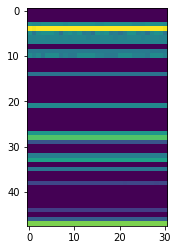

In [178]:
distance_round2compzones_by_step_id_min=distance_round2compzones_by_step_id.min("wwmf_2")

distance_round2compzones_comp_by_step_id_min=distance_round2compzones_comp_by_step_id.min("wwmf_2")

dist_round2compzones_sum_by_step_id_min=distance_round2compzones_by_step_id_min+distance_round2compzones_comp_by_step_id_min

plt.imshow(dist_round2compzones_sum_by_step_id_min)

In [179]:
step_zones_comp_hetero_and_multiple

array([ 3,  4,  5,  6,  7,  9, 10, 14, 21, 27, 28, 29, 32, 33, 35, 38, 44,
       46, 47])

In [182]:
# initialize
ind_compzone_distmin_round2_by_step=np.full([ds_masked_zones_comp_hetero.dims["step"]], np.nan)  
dist_comp_round2_sum_by_step_min=np.full([ds_masked_zones_comp_hetero.dims["step"]], np.nan) 
tps_sens_comp_round2=np.full([ds_masked_zones_comp_hetero.dims["step"]], np.nan)
tps_sens_comp_of_comp_round2=np.full([ds_masked_zones_hetero.dims["step"]], np.nan)

name_compzone_round2=['nan']*ds_masked_zones_hetero.dims["step"]

In [186]:
for i in step_zones_comp_hetero_and_multiple:

    if len(np.where(dist_round2compzones_sum_by_step_id_min.isel(step=i)[id_compzone_included[i]]==min(dist_round2compzones_sum_by_step_id_min.isel(step=i)[id_compzone_included[i]]))[0])==len(id_compzone_included[i]):
        print('Echeance '+str(i)+': no further zoning within the initial complementary winning zone '+zoneswinning_comp[i])
        tps_sens_comp_round2[i]=distance_round2compzones_by_step_id.isel(step=i).argmin("wwmf_2")[id_compzone_included[i]].max().values
        tps_sens_comp_of_comp_round2[i]=distance_round2compzones_comp_by_step_id.isel(step=i).argmin("wwmf_2")[id_compzone_included[i]].max().values
        print('Temps sensible in any new zone (of the complementary): '+str( tps_sens_comp_round2[i]))
        print('Temps sensible in any new complementary zone (of the complementary): '+str( tps_sens_comp_of_comp_round2[i]),'(Both shall be the same!)','\n')
    else:        
        ind_compzone_distmin_round2_by_step[i]=dist_round2compzones_sum_by_step_id_min.isel(step=i)[id_compzone_included[i]].argmin().values
        dist_comp_round2_sum_by_step_min[i]=dist_round2compzones_sum_by_step_id_min.isel(step=i)[id_compzone_included[i]].min().values
               
        tps_sens_comp_round2[i]=distance_round2compzones_by_step_id.isel(step=i).argmin("wwmf_2")[id_compzone_included[i]][int(ind_compzone_distmin_round2_by_step[i])].values        
        tps_sens_comp_of_comp_round2[i]=distance_round2compzones_comp_by_step_id.isel(step=i).argmin("wwmf_2")[id_compzone_included[i]][int(ind_compzone_distmin_round2_by_step[i])].values        
        
        name_compzone_round2[i]=str(dist_round2compzones_sum_by_step_id_min.isel(step=i).id[id_compzone_included[i]][int(ind_compzone_distmin_round2_by_step[i])].values)
        
        print('\nEcheance ',str(i),': YES! Further zoning applies within the initial winning zone ',zoneswinning_comp[i],',viz.:',name_compzone_round2[i])
        print('Temps sensible is: '+str( tps_sens_comp_round2[i]),'in the new winning zone')
        print('Temps sensible is: '+str( tps_sens_comp_of_comp_round2[i]),'in the new complementary zone','\n')
        


Echeance  3 : YES! Further zoning applies within the initial winning zone  4101+4102 ,viz.: 4102
Temps sensible is: 1.0 in the new winning zone
Temps sensible is: 5.0 in the new complementary zone 


Echeance  4 : YES! Further zoning applies within the initial winning zone  4101+4102+4104+4105+4106 ,viz.: 4101
Temps sensible is: 5.0 in the new winning zone
Temps sensible is: 2.0 in the new complementary zone 


Echeance  5 : YES! Further zoning applies within the initial winning zone  4101+4102+4104+4105+4106 ,viz.: 4101+4102
Temps sensible is: 3.0 in the new winning zone
Temps sensible is: 2.0 in the new complementary zone 


Echeance  6 : YES! Further zoning applies within the initial winning zone  4101+4104+4105+4106 ,viz.: 4105+4106
Temps sensible is: 2.0 in the new winning zone
Temps sensible is: 3.0 in the new complementary zone 

Echeance 7: no further zoning within the initial complementary winning zone 4101+4102+4103+4104+4105
Temps sensible in any new zone (of the complement

## (A priori plus nécessaire et anciennement dans la section A) Tentative de travailler par echeance en utilisant seulement les masks nécessaires

In [ ]:
# test sur l'echeance 2:
ds_distance_round2zones = distance_wwmf.get_pixel_distance_dept(ds_masked_zones_hetero,"compas") # 4D (step:48, latitude, longitude, wwmf_2)

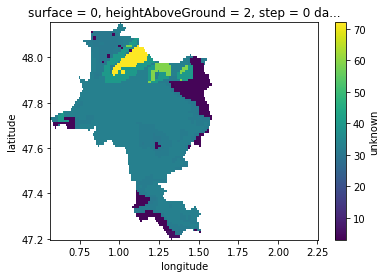

In [208]:
ds_masked_zones_hetero.isel(step=2).unknown.plot.imshow()

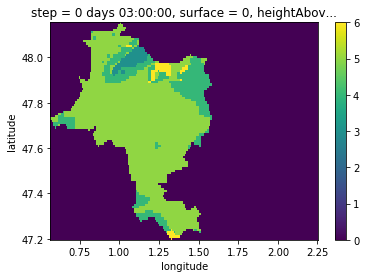

In [215]:
ds_distance_round2zones.isel(step=2).isel(wwmf_2=16).plot.imshow()

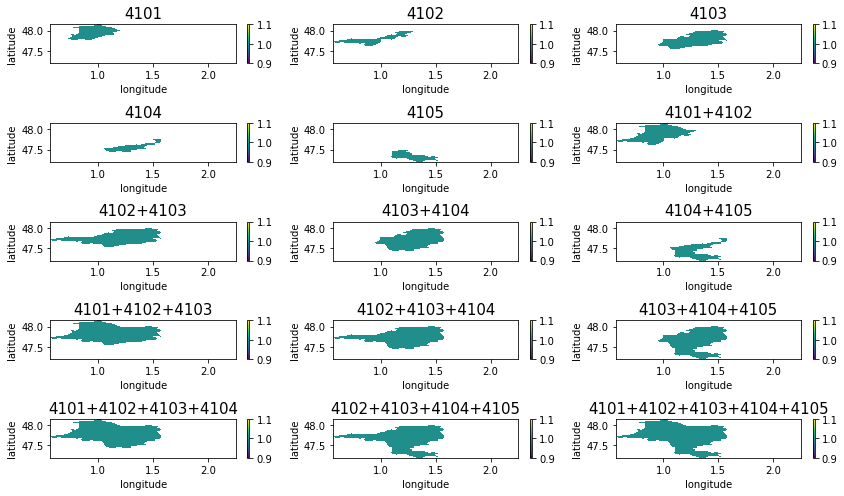

In [220]:
i=2
fig,axes = plt.subplots(nrows=5,ncols = 3,figsize=(12,7))
ax = axes.flat

for ii,i in enumerate(id_zone_included[i]):
    da_mask_round2.isel(id=i).plot.imshow(ax=ax[ii]);ax[ii].set_title(da_mask.id.values.tolist()[i],fontsize=15)
    
plt.tight_layout()

In [224]:
toto=da_mask_round2.isel(id=id_zone_included[2])
#toto.id

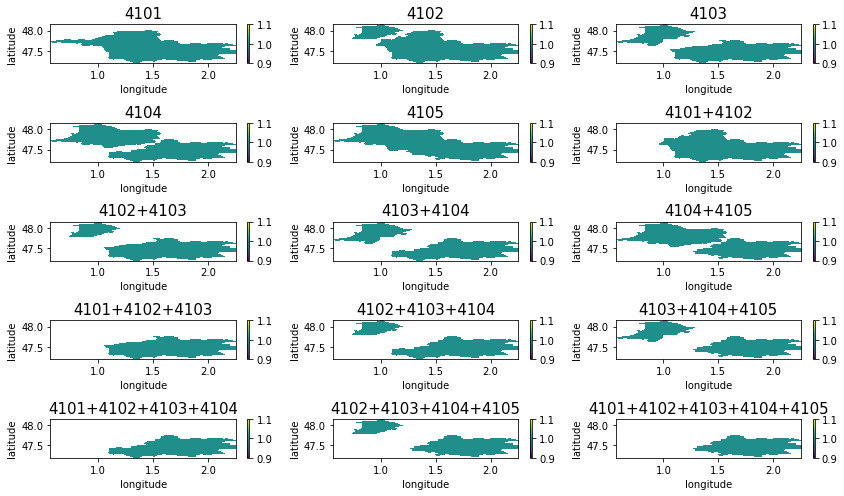

In [225]:
i=2
fig,axes = plt.subplots(nrows=5,ncols = 3,figsize=(12,7))
ax = axes.flat

for ii,i in enumerate(id_zone_included[i]):
    da_mask_comp_round2.isel(id=i).plot.imshow(ax=ax[ii]);ax[ii].set_title(da_mask.id.values.tolist()[i],fontsize=15)
    
plt.tight_layout()

In [227]:
toto_comp=da_mask_comp_round2.isel(id=id_zone_included[2])
#toto_comp.id

In [234]:
# La nouveauté est ici!!! (on perd la dimension echeance:step)
distance_toto_by_id = (ds_distance_round2zones_chunk.isel(step=2) * toto).sum(['latitude',"longitude"]).compute() # 2D (wwmf_2, id)

In [235]:
distance_toto_comp_by_id = (ds_distance_round2zones_chunk.isel(step=2) * toto_comp).sum(['latitude',"longitude"]).compute() # 2D (wwmf_2, id)

In [241]:
distance_toto_by_id.min("wwmf_2")

<xarray.DataArray (id: 15)>
array([1454.,  472.,  850.,   43.,  163., 1906., 1280.,  885.,  206.,
       2714., 1315., 1048., 2749., 1478., 2912.])
Coordinates:
    step               timedelta64[ns] 03:00:00
    surface            int64 0
    heightAboveGround  int64 2
  * id                 (id) object '4101' '4102' ... '4101+4102+4103+4104+4105'

In [242]:
distance_toto_comp_by_id.min("wwmf_2")

<xarray.DataArray (id: 15)>
array([1458., 2440., 2062., 2869., 2749., 1006., 1632., 2027., 2706.,
        198., 1597., 1864.,  163., 1434.,    0.])
Coordinates:
    step               timedelta64[ns] 03:00:00
    surface            int64 0
    heightAboveGround  int64 2
  * id                 (id) object '4101' '4102' ... '4101+4102+4103+4104+4105'

In [243]:
distance_toto_by_id.min("wwmf_2")+distance_toto_comp_by_id.min("wwmf_2")

<xarray.DataArray (id: 15)>
array([2912., 2912., 2912., 2912., 2912., 2912., 2912., 2912., 2912.,
       2912., 2912., 2912., 2912., 2912., 2912.])
Coordinates:
    step               timedelta64[ns] 03:00:00
    surface            int64 0
    heightAboveGround  int64 2
  * id                 (id) object '4101' '4102' ... '4101+4102+4103+4104+4105'

On obtient toujours ce résultat qui ne permet pas de choisir entre les zones donc il faut conclure que dans ce cas, ce deuxième round n aide pas

# Checking on Loir et Cher (FRB05)

In [284]:
da_mask_ref = xr.open_dataset("../GeoData/nc_departement/FRB05.nc")["mask"].squeeze("id")
da_mask_ref['latitude']=da_mask_ref['latitude'].round(5)
da_mask_ref['longitude']=da_mask_ref['longitude'].round(5)
ds=xr.open_dataset(fname)
ds['latitude']=ds['latitude'].round(5)
ds['longitude']=ds['longitude'].round(5)
dtemp=ds*da_mask_ref
ds_distance_ref = distance_wwmf.get_pixel_distance_dept(dtemp,"compas")
ds_distance_ref

<xarray.DataArray (step: 48, latitude: 93, longitude: 164, wwmf_2: 19)>
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
  

In [285]:
distance_by_step_wwmf = ds_distance_ref.sum(["longitude","latitude"])
distance_by_step_wwmf

<xarray.DataArray (step: 48, wwmf_2: 19)>
array([[3.4772e+04, 1.7356e+04, 6.4310e+03, 2.2280e+03, 8.2060e+03,
        2.7843e+04, 3.3869e+04, 4.3529e+04, 5.5051e+04, 4.9555e+04,
        6.1125e+04, 3.7056e+04, 4.3034e+04, 3.7278e+04, 4.3256e+04,
        3.7566e+04, 3.7572e+04, 3.9299e+04, 3.9353e+04],
       [3.5168e+04, 1.7529e+04, 6.0180e+03, 2.0510e+03, 7.9040e+03,
        2.7569e+04, 3.3422e+04, 4.3267e+04, 5.5053e+04, 4.9120e+04,
        6.0906e+04, 3.7139e+04, 4.2992e+04, 3.7249e+04, 4.3102e+04,
        3.7359e+04, 3.7359e+04, 3.9245e+04, 3.9245e+04],
       [3.6652e+04, 1.9009e+04, 6.6580e+03, 4.5130e+03, 1.0044e+04,
        2.5972e+04, 3.1724e+04, 4.1258e+04, 5.3847e+04, 4.7010e+04,
        5.9891e+04, 3.6144e+04, 4.1675e+04, 3.6087e+04, 4.1618e+04,
        3.6386e+04, 3.6656e+04, 3.9281e+04, 3.9559e+04],
       [3.4076e+04, 1.7595e+04, 1.0827e+04, 9.3630e+03, 1.4651e+04,
        2.6755e+04, 3.2620e+04, 4.1614e+04, 5.4720e+04, 4.7479e+04,
        6.1211e+04, 3.1314e+04, 3.6602e+04, 3.4246e+04, 3.9534e+04,
        3.6129e+04, 3.6845e+04, 3.8710e+04, 3.9856e+04],
       [3.7693e+04, 2.1230e+04, 1.2744e+04, 1.6452e+04, 2.1604e+04,
        2.2210e+04, 2.8616e+04, 3.5847e+04, 5.1476e+04, 4.2293e+04,
        5.9161e+04, 2.6692e+04, 3.1882e+04, 3.0276e+04, 3.5428e+04,
        3.1212e+04, 3.2835e+04, 3.7132e+04, 4.0041e+04],
       [4.0923e+04, 2.2758e+04, 8.6870e+03, 1.2959e+04, 1.7455e+04,
        1.9850e+04, 2.5579e+04, 3.4426e+04, 5.1072e+04, 4.0155e+04,
        5.8034e+04, 3.0221e+04, 3.4717e+04, 3.1282e+04, 3.5778e+04,
        3.2021e+04, 3.2943e+04, 3.8634e+04, 4.0789e+04],
       [4.5899e+04, 2.7204e+04, 8.0400e+03, 1.5299e+04, 1.9946e+04,
        1.3910e+04, 2.1335e+04, 2.9413e+04, 4.6629e+04, 3.6838e+04,
        5.6832e+04, 3.2270e+04, 3.6917e+04, 3.0097e+04, 3.4744e+04,
        3.2700e+04, 3.2895e+04, 4.1633e+04, 4.4606e+04],
       [4.9226e+04, 3.1324e+04, 1.0394e+04, 2.0870e+04, 2.6350e+04,
        8.9820e+03, 1.8881e+04, 2.4515e+04, 4.1686e+04, 3.4414e+04,
        5.6004e+04, 3.1632e+04, 3.7112e+04, 2.7708e+04, 3.3188e+04,
        3.1962e+04, 3.2127e+04, 4.3334e+04, 4.7918e+04],
       [4.7223e+04, 3.1124e+04, 1.3083e+04, 2.2189e+04, 2.9261e+04,
        1.0310e+04, 2.2265e+04, 2.5632e+04, 4.0294e+04, 3.7587e+04,
        5.7132e+04, 3.1705e+04, 3.8777e+04, 2.7950e+04, 3.5022e+04,
        3.2457e+04, 3.2833e+04, 4.3376e+04, 4.8635e+04],
       [4.6903e+04, 3.1146e+04, 1.3113e+04, 2.1119e+04, 2.8793e+04,
        1.0682e+04, 2.3447e+04, 2.6264e+04, 3.9670e+04, 3.9029e+04,
        5.7526e+04, 3.3399e+04, 4.1073e+04, 2.8656e+04, 3.6330e+04,
        3.3631e+04, 3.3747e+04, 4.4104e+04, 4.9311e+04],
       [4.5364e+04, 2.9776e+04, 1.2804e+04, 1.9286e+04, 2.6766e+04,
        1.2637e+04, 2.4769e+04, 2.8250e+04, 4.1350e+04, 4.0382e+04,
        5.8134e+04, 3.4031e+04, 4.1511e+04, 2.9742e+04, 3.7222e+04,
        3.4672e+04, 3.4672e+04, 4.4152e+04, 4.8804e+04],
       [3.7807e+04, 2.0630e+04, 7.5290e+03, 6.0970e+03, 1.2464e+04,
        2.3829e+04, 3.1349e+04, 3.9527e+04, 5.1490e+04, 4.7047e+04,
        6.0163e+04, 3.6604e+04, 4.2971e+04, 3.5457e+04, 4.1824e+04,
        3.6616e+04, 3.6616e+04, 4.0398e+04, 4.1551e+04],
       [4.1166e+04, 2.0591e+04, 3.8600e+03, 6.4430e+03, 9.0840e+03,
        2.1069e+04, 2.3936e+04, 3.6767e+04, 5.4927e+04, 3.9634e+04,
        5.8020e+04, 3.3149e+04, 3.5790e+04, 3.3585e+04, 3.6226e+04,
        3.4473e+04, 3.4473e+04, 3.9471e+04, 3.9697e+04],
       [4.3321e+04, 2.0992e+04, 2.5990e+03, 8.0450e+03, 8.5780e+03,
        1.8775e+04, 1.9319e+04, 3.4473e+04, 5.6280e+04, 3.5017e+04,
        5.6835e+04, 3.0548e+04, 3.1081e+04, 3.1907e+04, 3.2440e+04,
        3.3288e+04, 3.3288e+04, 3.9256e+04, 3.9267e+04],
       [4.2948e+04, 2.0461e+04, 3.1060e+03, 8.8630e+03, 8.8820e+03,
        1.8819e+04, 1.8838e+04, 3.4513e+04, 5.6997e+04, 3.4532e+04,
        5.7016e+04, 2.9369e+04, 2.9388e+04, 3.1423e+04, 3.1442e+04,
        3.3473e+04, 3.3473e+04, 3.9257e+04, 3.9257e+04],
       [4.7038e+04, 2.3505e+04, 4.2000e+01,

In [286]:
distance_by_step_wwmf.min("wwmf_2").compute()

<xarray.DataArray (step: 48)>
array([ 2228.,  2051.,  4513.,  9363., 12744.,  8687.,  8040.,  8982.,
       10310., 10682., 12637.,  6097.,  3860.,  2599.,  3106.,    42.,
           0.,     0.,   164.,  1666.,  5380.,  4428.,  1540.,  1718.,
        1318.,   858.,  1906.,  4654.,  5644.,  7388.,  3565.,  4293.,
        5720.,  8102.,  5954.,  3766.,   400.,  2294.,  7054.,  3160.,
        1264.,  1942.,   334.,  3236.,  8816.,  9340., 11394., 10409.])
Coordinates:
  * step               (step) timedelta64[ns] 01:00:00 ... 2 days 00:00:00
    surface            int64 0
    heightAboveGround  int64 2
    id                 <U5 'FRB05'

In [288]:
distance_by_step_wwmf["wwmf_2"][distance_by_step_wwmf.argmin("wwmf_2")]

<xarray.DataArray 'wwmf_2' (step: 48)>
array([4, 4, 4, 4, 3, 3, 3, 6, 6, 6, 6, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 3, 3, 3, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6])
Coordinates:
    surface            int64 ...
    heightAboveGround  int64 ...
    id                 <U5 'FRB05'
    wwmf_2             (step) int64 4 4 4 4 3 3 3 6 6 6 ... 8 6 6 6 6 6 6 6 6 6
  * step               (step) timedelta64[ns] 01:00:00 ... 2 days 00:00:00

## On charge le fichier du Loir et Cher
A priori on a bien la même chose 

In [35]:
df_LoirCher = pd.read_csv("../notebook_gabriel/scores_advanced/FRB05_scores_202001260100.csv")

In [51]:
df_LoirCher[["WME","WME_dist"]]

,WME,WME_dist
0,4,2228
1,4,2051
2,4,4513
3,4,9363
4,3,12744
5,3,8687
6,3,8040
7,6,8982
8,6,10310
9,6,10682


In [19]:
def to_categorical(y, num_classes=None, dtype='float32'):
  """Converts a class vector (integers) to binary class matrix.
  E.g. for use with categorical_crossentropy.
  Arguments:
      y: class vector to be converted into a matrix
          (integers from 0 to num_classes).
      num_classes: total number of classes.
      dtype: The data type expected by the input. Default: `'float32'`.
  Returns:
      A binary matrix representation of the input. The classes axis is placed
      last.
  """
  y = np.array(y, dtype='int')
  input_shape = y.shape
  if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
    input_shape = tuple(input_shape[:-1])
  y = y.ravel()
  if not num_classes:
    num_classes = np.max(y) + 1
  n = y.shape[0]
  categorical = np.zeros((n, num_classes), dtype=dtype)
  categorical[np.arange(n), y] = 1
  output_shape = input_shape + (num_classes,)
  categorical = np.reshape(categorical, output_shape)
  return categorical

def conversion(ds,name):
    """convert wwmf into wme (compas) or w1 (agat) code"""
    
    file_CodesWWMF= '../utils/CodesWWMF.csv'
    df_WWMF = pd.read_csv(file_CodesWWMF,usecols = (0,1,2,3,6,7),sep=',')
    if name=="compas":
        var_name="wme_arr"
        col_name="Code WME"
        ds[var_name]=ds.unknown
    elif name=="agat":
        var_name="w1_arr"
        col_name="Code W1"
        ds[var_name]=ds.unknown       
        
    elif name=="compas_asym":
        var_name="wme_asym_arr"
        col_name="Code WME"
        ds[var_name]=ds.unknown      
    elif name=="agat_asym":
        var_name="w1_asym_arr"
        col_name="Code W1"
        ds[var_name]=ds.unknown 

    for iwwmf,wwmf in enumerate(df_WWMF["Code WWMF"]):
        ds[var_name]=ds[var_name].where(ds.unknown!=wwmf,df_WWMF[col_name][iwwmf])
    return ds

def xarray_cat(da,mask=None):
    y = da.astype(np.uint8).values
    cat = to_categorical(y)
    sh = cat.shape 
    dout = xr.Dataset()
    dout[da.name] = (tuple(list(da.dims) + ["wwmf"]),cat)
    for dim in da.dims: 
        dout[dim] = da[dim]
    dout["wwmf"] = range(sh[-1])
    #dout = dout.sel(wwmf=slice(1,sh[-1]))# On vire l'indice 0
    return dout 
    
def get_matrix(name):
    """
    Retourne la matrice de distance sous forme de xarray 
    """
    if name == "compas":
        fname_dist = '../utils/distance_compas.csv'
        df_dist = pd.read_csv(fname_dist,sep=',')
        var_name="wme_arr"
        varsh="wme_c_"
        
    elif name == "agat":
        fname_dist = '../utils/distance_agat.csv'
        df_dist = pd.read_csv(fname_dist,sep=',')  
        var_name="w1_arr"
        varsh="w1_c_"
        
    elif name == "compas_asym":
        fname_dist = '../utils/distance_compas_asym.csv'
        df_dist = pd.read_csv(fname_dist,sep=',')
        var_name="wme_asym_arr"
        varsh="wme_asym_c_"
        
    elif name == "agat_asym":
        fname_dist = '../utils/distance_agat_asym.csv'
        df_dist = pd.read_csv(fname_dist,sep=',')  
        var_name="w1_asym_arr"
        varsh="w1_asym_c_"

    col_name = df_dist.columns[0]
    index = df_dist[col_name]
    values = df_dist.set_index(col_name).values
    mat = xr.Dataset()
    mat["distance"] = (("wwmf","wwmf_2"),values)
    mat["wwmf"] = index.values
    mat["wwmf_2"] = index.values
    mat["distance"].attrs["var_name"] = var_name
    return mat["distance"]

def get_pixel_distance_dept(ds_dept,name):
    " On donne en entree le dataset du departement"
    dconvert = conversion(ds_dept,name)
    distance_matrix = get_matrix(name)
    dcat = xarray_cat(dconvert[distance_matrix.var_name])
    return dcat[distance_matrix.var_name].dot(distance_matrix)